In [1]:
%cd G:\Meine Ablage\TechLabs\Scam Busters

G:\Meine Ablage\TechLabs\Scam Busters


In [2]:
# helpful variables for dev
feature_list = ['return_1hrs_to_cutoff', 'return_1hrs_to_1h',
       'btc_volume_1hrs_to_cutoff', 'btc_volume_1hrs_to_1h',
       'coin_volume_1hrs_to_cutoff', 'coin_volume_1hrs_to_1h',
       'return_3hrs_to_cutoff', 'return_3hrs_to_1h',
       'btc_volume_3hrs_to_cutoff', 'btc_volume_3hrs_to_1h',
       'coin_volume_3hrs_to_cutoff', 'coin_volume_3hrs_to_1h',
       'return_12hrs_to_cutoff', 'return_12hrs_to_1h',
       'btc_volume_12hrs_to_cutoff', 'btc_volume_12hrs_to_1h',
       'coin_volume_12hrs_to_cutoff', 'coin_volume_12hrs_to_1h',
       'return_24hrs_to_cutoff', 'return_24hrs_to_1h',
       'btc_volume_24hrs_to_cutoff', 'btc_volume_24hrs_to_1h',
       'coin_volume_24hrs_to_cutoff', 'coin_volume_24hrs_to_1h',
       'return_36hrs_to_cutoff', 'return_36hrs_to_1h',
       'btc_volume_36hrs_to_cutoff', 'btc_volume_36hrs_to_1h',
       'coin_volume_36hrs_to_cutoff', 'coin_volume_36hrs_to_1h',
       'return_48hrs_to_cutoff', 'return_48hrs_to_1h',
       'btc_volume_48hrs_to_cutoff', 'btc_volume_48hrs_to_1h',
       'coin_volume_48hrs_to_cutoff', 'coin_volume_48hrs_to_1h',
       'return_60hrs_to_cutoff', 'return_60hrs_to_1h',
       'btc_volume_60hrs_to_cutoff', 'btc_volume_60hrs_to_1h',
       'coin_volume_60hrs_to_cutoff', 'coin_volume_60hrs_to_1h',
       'return_72hrs_to_cutoff', 'return_72hrs_to_1h',
       'btc_volume_72hrs_to_cutoff', 'btc_volume_72hrs_to_1h',
       'coin_volume_72hrs_to_cutoff', 'coin_volume_72hrs_to_1h',
       'market_cap', 'coin_age']
target = 'pumped'

# imports
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import mlflow
from utils import utils
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, f1_score, recall_score, precision_score

import os

In [3]:
class RandomForestModel:
    """
    RandomForestClassifier to predict crypto pump and dump schemes
    """

    def __init__(self, **run_params):
        """
        Constructor
        :param run_params: parameters (key-value) for the run such as random_state etc
        """

        # Number of trees in random forest
        n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
        # Number of features to consider at every split
        max_features = ['auto', 'sqrt']
        # Maximum number of levels in tree
        max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
        max_depth.append(None)
        # Minimum number of samples required to split a node
        min_samples_split = [2, 5, 10]
        # Minimum number of samples required at each leaf node
        min_samples_leaf = [1, 2, 4]
        # Method of selecting samples for training each tree
        bootstrap = [True, False]
        # Create the random grid
        random_grid = {'n_estimators': n_estimators,
                    'max_features': max_features,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'bootstrap': bootstrap}

        self.randomforestclassifier = RandomForestClassifier()
        self.rfc_random = RandomizedSearchCV(estimator=self.randomforestclassifier,
            scoring = ['f1','f1_weighted','recall','precision'], refit='f1', # scoring settings
            param_distributions = random_grid, n_iter = run_params['n_training_iterations'],
            cv = run_params['cross_validation_splits'], verbose=2, random_state=run_params['random_state'], n_jobs = -1) # additional settings
        self._params = run_params
        self.data, self.real_dataset_id = utils.load_data(run_params['data_root'],run_params['dataset_id'])
        logger.info(f'run parameters: {run_params}')

    @classmethod
    def create_instance(cls, **run_params):
        return cls(**run_params)

    @property
    def model(self):
        """
        Getter for the property the model
        :return: return the trained decision tree model
        """

        return self.rfc_random

    @property
    def params(self):
        """
        Getter for the property the model
          :return: return the model params
        """
        return self._params

    def mlflow_run(self, run_name="rfc_model_training"):
        """
        This method trains, computes metrics, and logs all metrics, parameters,
        and artifacts for the current run
        :param run_name: Name of the experiment as logged by MLflow
        :return: MLflow Tuple (experiment_id, run_id)
        """

        with mlflow.start_run(run_name=run_name) as run:

            # get current run and experiment id
            run_id = run.info.run_uuid
            experiment_id = run.info.experiment_id
            logger.info(f'run started. id: {run_id}')

            # check data quality
            # missing data
            na_counts = self.data.isna().sum().sum()
            na_ratio = na_counts / self.data.shape[0]*self.data.shape[1]
            logger.info(f'na_count is at {na_counts}. na_ratio is at {na_ratio}')

            # split the data into train and test
            x_train, x_test, y_train, y_test = train_test_split(
                self.data[feature_list], self.data[target], 
                test_size=self._params['test_size'], random_state=self._params['random_state'],
                stratify=self.data[target])
            logging.info(f'After the split there are ')

            # data transformation
            if self._params['transformation']=='zscore':
                print('trying zscore now')
                zscore_scaler = StandardScaler()
                # use training data to fit and transform
                x_train = pd.DataFrame(zscore_scaler.fit_transform(x_train.values))
                x_train.columns = feature_list
                # transform other x_data based on the training data fit
                x_test = pd.DataFrame(zscore_scaler.transform(x_test.values))
                x_test.columns = feature_list
                # round the values
                x_train = x_train.round(10)
                x_test = x_test.round(10)
                x_train.to_csv(f'data/06_debug/x_train.csv')
                x_test.to_csv('data/06_debug/x_test.csv')
                print('zscore done')

            # train and tune model
            self.rfc_random.fit(x_train, list(y_train))
            self.rfmodel = self.rfc_random.best_estimator_
            # make predictions
            y_probabilities = self.rfmodel.predict_proba(x_test)
            y_predicted = (y_probabilities [:,1] >= self._params['prediction_threshold']).astype('int')

            # Log model and params using the MLflow sklearn APIs
            mlflow.sklearn.log_model(self.rfmodel, "random_forest_classifier")
            mlflow.log_params(self.rfc_random.best_params_)
            mlflow.log_param('dataset_id',self.real_dataset_id)
            mlflow.log_param('features',feature_list)

            cv_df = pd.DataFrame(self.rfc_random.cv_results_)
            best_model_metadata = cv_df.loc[self.rfc_random.best_index_]
            # log metrics in mlflow
            mlflow.log_metric('train_f1', best_model_metadata.mean_test_f1)
            mlflow.log_metric('train_f1_weighted', best_model_metadata.mean_test_f1_weighted)
            mlflow.log_metric('train_precision', best_model_metadata.mean_test_precision)
            mlflow.log_metric('train_recall', best_model_metadata.mean_test_recall)
            mlflow.log_metric('test_recall',recall_score(y_test,y_predicted))
            mlflow.log_metric('test_precision',precision_score(y_test,y_predicted))
            mlflow.log_metric('test_f1_score',f1_score(y_test,y_predicted))
            mlflow.log_metric('test_f1_score_weighted',f1_score(y_test,y_predicted,average='weighted'))


            # # create confusion matrix plot
            # print(y_test, y_pred, '--------')

            # plt_cm, fig_cm, ax_cm = utils.plot_confusion_matrix(y_test, y_pred, y_test,
            #                                                     title="Classification Confusion Matrix")

            # temp_name = "confusion-matrix.png"
            # fig_cm.savefig(temp_name)
            # mlflow.log_artifact(temp_name, "confusion-matrix-plots")
            # try:
            #     os.remove(temp_name)
            # except FileNotFoundError as e:
            #     print(f"{temp_name} file is not found")

            print("<->" * 40)
            print(f"Inside MLflow Run with run_id {run_id} and experiment_id {experiment_id}")
            
            # create roc plot
            plot_file = "roc-auc-plot.png"
            probs = y_probabilities[:, 1]
            fpr, tpr, thresholds = roc_curve(y_test, probs)
            plt_roc, fig_roc, ax_roc = utils.create_roc_plot(fpr, tpr)
            fig_roc.savefig(plot_file)
            mlflow.log_artifact(plot_file, "roc-auc-plots")
            try:
                os.remove(plot_file)
            except FileNotFoundError as e:
                print(f"{plot_file} file is not found")

            return experiment_id, run_id

trying zscore now
zscore done
Fitting 20 folds for each of 20 candidates, totalling 400 fits
<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
Inside MLflow Run with run_id bf20ea4a58464594b113d9ade63a33ed and experiment_id 0
<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->


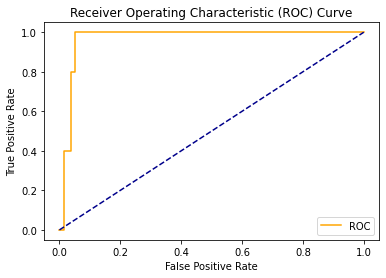

In [4]:
params = {
    'data_root':'data/05_engineered_features/',
    'dataset_id':'newest',
    'random_state':0,
    'transformation':'zscore',
    'test_size':0.2,
    'prediction_threshold':0.2,
    'cross_validation_splits':20,
    'n_training_iterations':20
}

# logging

import datetime as dt
import logging
run_id = dt.datetime.now().strftime("%Y-%m-%d_%H%M%S")
logging_path = 'metadata/logging/pipeline_'+run_id+'.log'
logging.basicConfig(level=logging.DEBUG, filename=logging_path,force=True)
logger = logging.getLogger(__name__)
logging.info('Run started')

try:
    dtc = RandomForestModel.create_instance(**params)
except Exception as e:
    logger.exception(
        "Unable to create Model instance: %s", e)
try:
    exp_id, run_id = dtc.mlflow_run()
    logger.info(f"MLflow Run completed with run_id {exp_id} and experiment_id {run_id}")
except Exception as e:
    logger.exception(
        'Unable to run pipeline: %s', e)

print("<->" * 40)

In [5]:
test_df = pd.read_csv('data/05_engineered_features/2022-03-19.csv')

In [6]:
# train new model with the best parameters
from sklearn.ensemble import RandomForestClassifier

new_model = RandomForestClassifier(
    #max_depth=40,
    max_features='auto',
    min_samples_leaf=2, 
    min_samples_split=2,
    n_estimators=600,
    bootstrap=False)
x = test_df[feature_list]
y=test_df.pumped

In [8]:
new_model.fit(x,y)

RandomForestClassifier(bootstrap=False, min_samples_leaf=2, n_estimators=600)

In [9]:
new_model.predict(x)

array([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [10]:
(new_model.predict_proba(x)[:,1]>.4).astype('int')

array([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [11]:
feature_importances = pd.Series(new_model.feature_importances_)
feature_importances.index = feature_list

In [12]:
(feature_importances*100).sort_values(ascending=False)

market_cap                     9.543220
coin_age                       7.898857
return_24hrs_to_cutoff         4.111678
return_3hrs_to_cutoff          3.583232
return_12hrs_to_cutoff         3.433333
return_72hrs_to_1h             3.148301
return_24hrs_to_1h             3.144525
return_36hrs_to_cutoff         3.116036
return_1hrs_to_cutoff          2.911367
btc_volume_24hrs_to_cutoff     2.665565
btc_volume_36hrs_to_cutoff     2.562366
return_36hrs_to_1h             2.481174
return_12hrs_to_1h             2.444857
return_48hrs_to_cutoff         2.442061
return_60hrs_to_cutoff         2.157441
return_48hrs_to_1h             2.156513
btc_volume_60hrs_to_1h         2.113528
btc_volume_24hrs_to_1h         1.999305
return_60hrs_to_1h             1.989749
return_72hrs_to_cutoff         1.946049
btc_volume_36hrs_to_1h         1.811288
btc_volume_3hrs_to_cutoff      1.793719
btc_volume_60hrs_to_cutoff     1.770624
btc_volume_1hrs_to_1h          1.637857
btc_volume_1hrs_to_cutoff      1.538130


In [14]:
x_fake = pd.concat([x.sample(50) for i in range(8)])
len(x_fake)

400

In [15]:
predictions = pd.DataFrame(new_model.predict_proba(x_fake))[[1]]
predictions.columns = ['pump_probability']

In [20]:
pump_threshold = .3
predictions.loc[:,'will_be_pumped'] = predictions.pump_probability > pump_threshold

<AxesSubplot:>

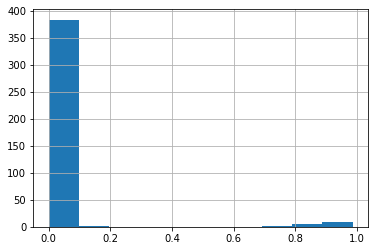

In [22]:
predictions.pump_probability.hist()

In [21]:
predictions.will_be_pumped.sum()

15

In [ ]:
test_df.loc[64]

Unnamed: 0                                 64
return_1hrs_to_cutoff                1.003185
return_1hrs_to_1h                    1.019512
btc_volume_1hrs_to_cutoff            4.021704
btc_volume_1hrs_to_1h                1.288304
coin_volume_1hrs_to_cutoff           634077.0
coin_volume_1hrs_to_1h               210970.0
return_3hrs_to_cutoff                1.058824
return_3hrs_to_1h                    1.041528
btc_volume_3hrs_to_cutoff            5.794416
btc_volume_3hrs_to_1h                3.256795
coin_volume_3hrs_to_cutoff           926071.0
coin_volume_3hrs_to_1h               539632.0
return_12hrs_to_cutoff               1.088083
return_12hrs_to_1h                   1.057336
btc_volume_12hrs_to_cutoff          13.504047
btc_volume_12hrs_to_1h              10.345439
coin_volume_12hrs_to_cutoff         2234053.0
coin_volume_12hrs_to_1h             1746869.0
return_24hrs_to_cutoff               1.139241
return_24hrs_to_1h                   1.133816
btc_volume_24hrs_to_cutoff        